# ONLINEADS 

#### Описание задачи
  > Международная бизнес-площадка запустила тестовую рекламу в интернете на жителей Москвы и Санкт-Петербурга. После проведения рекламной кампании были собраны данные о пользователях перешедших на сайт.

#### Цель задачи
  > Маркетологам запустистившим рекламные кампании нужно определить, какие пользователи в будущем будут регистрироваться на площадке (с высокой конверсией).

----

#### Описание признаков:


| Variable  | Definition | Key |
| --- |:---:| ---:|
| ID | Идентификатор пользователя перешедшего на сайт |  |
| Age | Возраст | 18‑24 года = 0; 25‑34 года = 1; 35‑44 года = 2; 45-54 года = 3; 55 лет и старше = 4 |
| Gender | Пол | Неизвестный = 0; Мужской = 1; Женский = 2 |
| Interest | Интересы | Бизнес = 0; Литература = 1 ; Кино = 2; Семья и дети = 3; Туризм = 4; Автомобили = 5; Кулинария = 6; Недвижимость = 7; Обустройство = 8; Мобильная связь и интернет = 9  |
| VisitTime | Время визита на сайт | От 00:00 до 23:00. Каждое число из набора данных соответствует определенному часу |
| City | Город | Москва = 0; Санкт-Петербург  = 1 |
| Device | Тип устройства | ПК = 0; Смартфон = 1 |
| OC | Операционная система | Mac OS = 0; Windows = 1; Android = 2; IOS = 3; |
| VisitPage | Страница на которую попал пользователь при клике на рекламу | Главная страница = 0; Специально разработанная для рекламной кампании страница = 1 |
| AdsTool | Источник перехода | Таргетированная реклама = 0; Контекстная реклама = 1; Прямые переходы = 2; SEO = 3; Социальные сети = 4; Остальные = 5|
| VisitNumber | Является ли переход на сайт первым визитом посетителя? | Новые посетители = 0; Вернувшиеся посетители = 1|
| ViewedPage | Количество просмотренных страниц перед регистрацией | 32-63 страниц = 0 ; 16-31 страниц = 1 ; 8-15 страниц = 2 ; 4-7 страниц = 3 ; 2-3 страниц = 4 ; 1 страница = 5 ; Остальные = 6 |
| Registration | Пользователь зарегистрировался | Да = 1; Нет = 0 |

In [35]:
import numpy as np
import pandas as pd
import pylab as pl
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, r2_score
from graphviz import Source
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import subprocess
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as metrics
from os import system
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Функция вывода таблицы результатов по модели

In [56]:
def plot_score_table(x):
    columns = ['Model', 'Accuracy', 'AUC', 'RMSE', 'R2', 'Cross_Val']

    fig, ax = plt.subplots(dpi=140)

    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    df = pd.DataFrame(x, columns=columns)

    ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

    fig.tight_layout()

    plt.show()
    plt.close()

### Функция отрисовки AUC кривой

In [57]:
def show_auc(predict):
    fpr, tpr, threshold = metrics.roc_curve(y_test, predict)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Функция считающая оценки построенной модели

In [98]:
def count_score(model):
    # оцениваем точность
    current_score = model.score(X_test, y_test)

    # оценка при кросс-валидации
    val_score = max(cross_val_score(model, X_test, y_test, cv=5))

    #генерируются предсказания, т.к у x еще нет значений, данный метод
    #возвращает ID и значение, к какому классу, по его мнению, относится то или иное значение
    predict = model.predict_proba(X_test)

    # записываем только значения
    predict = predict[:, 1]

    # вычисление площади под ROC-кривой
    auc = roc_auc_score(y_test, predict)

    # вычисление среднеквадратичной ошибки
    rmse = np.sqrt(mean_squared_error(y_test, predict))

    # вычисление коэффициента детерминизации
    r2 = r2_score(y_test, predict)
    
    return {'accuracy':current_score,
            'auc':auc,
            'rmse':rmse, 
            'r2': r2, 
            'val_score': val_score,
            'predict':predict}

### 1. Загрузка данных

In [143]:
data = pd.read_excel('dataset/Gover4.xlsx', sheet_name=0, index_col=0)
data.head()

,Age,Gender,Interest,VisitTime,City,Device,OS,VisitPage,AdsTool,VisitNumber,ViewedPage,Registration
ClientID,,,,,,,,,,,,
1,0,1,0,14,1,0,1,0,0,0,0,1
2,0,2,0,8,0,0,1,1,2,1,2,1
3,2,1,0,21,1,0,1,0,3,0,2,1
4,0,1,0,23,1,0,0,1,3,1,0,1
5,2,0,0,12,0,0,1,0,0,1,4,1


### 2. Выведем, описательную статистику , проверим корреляции между признаками.

In [144]:
print(data.shape)
print(data.info())

(20000, 12)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 1 to 20000
Data columns (total 12 columns):
Age             20000 non-null int64
Gender          20000 non-null int64
Interest        20000 non-null int64
VisitTime       20000 non-null int64
City            20000 non-null int64
Device          20000 non-null int64
OS              20000 non-null int64
VisitPage       20000 non-null int64
AdsTool         20000 non-null int64
VisitNumber     20000 non-null int64
ViewedPage      20000 non-null int64
Registration    20000 non-null int64
dtypes: int64(12)
memory usage: 2.0 MB
None


> В этом датасете 12 признаков, из которых 1 целевой, и 20 000 наблюдений

In [145]:
data.describe()

,Age,Gender,Interest,VisitTime,City,Device,OS,VisitPage,AdsTool,VisitNumber,ViewedPage,Registration
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,1.444550,1.308550,2.686650,12.566800,0.490250,0.490800,1.350200,0.529300,1.978850,0.547950,2.542000,0.500000
std,1.408483,0.695752,2.997684,6.110156,0.499917,0.499928,0.962084,0.499153,1.767048,0.497708,1.914764,0.500013
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,8.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,2.000000,13.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,2.000000,0.500000
75%,3.000000,2.000000,5.000000,18.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,4.000000,1.000000
max,4.000000,2.000000,9.000000,23.000000,1.000000,1.000000,3.000000,1.000000,5.000000,1.000000,6.000000,1.000000


> Заметим, что в датасете нет пропущенных значений

Text(0.5, 1, 'Missing values heatmap')

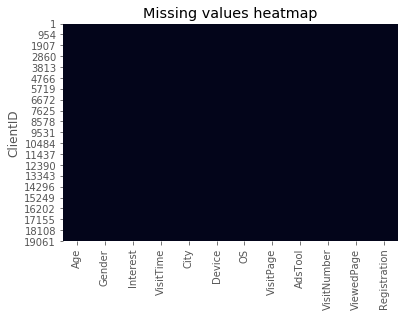

In [146]:
data.isnull().sum()
sns.heatmap(data.isnull(), cbar = False).set_title("Missing values heatmap")

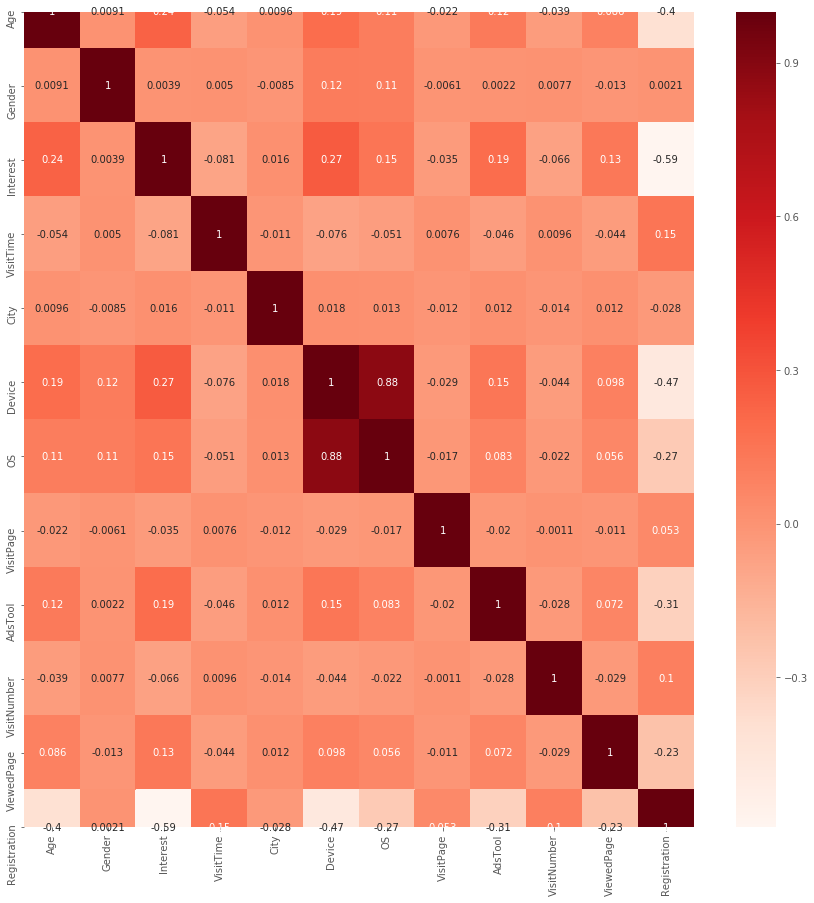

In [147]:
plt.figure(figsize=(15, 15))
correlation_matrix = data.corr()  
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

TODO markdown поясни за корреляцию

#### Удалим целевую переменную

In [148]:
X = data
y = data['Registration'].astype('int')
X.drop(['Registration'], axis=1, inplace=True)

### 3. Разбиение на обучение и контроль

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Рассмотрим модели и выберем лучшую

## 1. Деревья

In [190]:
tree=DecisionTreeClassifier(max_depth=5, random_state=17)
tree.fit(X_train, y_train)
print('Результат на обучающей выборке: ', tree.score(X_train, y_train))
print('Результат на тестовой выборке: ', tree.score(X_test, y_test))

Результат на обучающей выборке:  0.875
Результат на тестовой выборке:  0.861


> **Подбор лучших параметров**

In [196]:
tree_params = {'max_depth': list(range(1,15)), 
               'min_samples_leaf': list(range(1,19)),
               'criterion': ('entropy','gini')}

tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1,
                        verbose=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:   23.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=17,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ('entropy', 'gini'),
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
      

In [197]:
tree_grid.best_params_

{'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 18}

In [198]:
tree_grid.best_score_

0.888

**Попробуем увеличить значения параметров и убедимся, что лучшие параметры найдены верно**

In [199]:
tree_params2 = {'max_depth': list(range(12,20)), 
               'min_samples_leaf': list(range(18,24)),
               'criterion': ('entropy','gini')}

tree_grid2 = GridSearchCV(tree, tree_params2,
                         cv=5, n_jobs=-1,
                        verbose=True)
tree_grid2.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    4.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=17,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ('entropy', 'gini'),
                         'max_depth': [12, 13, 14, 15, 16, 17, 18, 19],
            

In [200]:
tree_grid2.best_params_

{'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 18}

In [188]:
tree_grid2.best_score_

0.8860714285714286

**Построим дерево по найденным параметрам**

In [207]:
tree2=DecisionTreeClassifier(max_depth=12,criterion='entropy', min_samples_leaf=18)
tree2.fit(X_train, y_train)
dotfile = open(r'OnlineAds_tree.dot', 'w')

graph = Source(export_graphviz(tree2, out_file=dotfile, 
               rounded = True, proportion = False, 
                precision = 2, filled = True))
dotfile.close()
system("dot -Tpng OnlineAds_tree.dot -o OnlineAds_tree.png")

0

#### Проанализируем полученное дерево

TODO

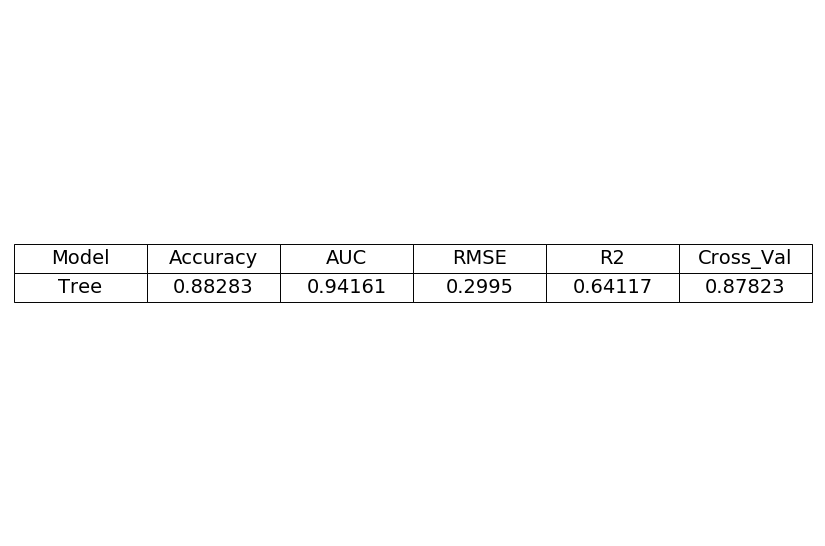

In [202]:
tree_table = []
scores = count_score(tree2)
tree_table.append(['Tree',
                   round(scores['accuracy'], 5),
                   round(scores['auc'], 5),
                   round(scores['rmse'], 5),
                   round(scores['r2'], 5),
                   round(scores['val_score'], 5)])
plot_score_table(tree_table)

### Построим ROC-кривую

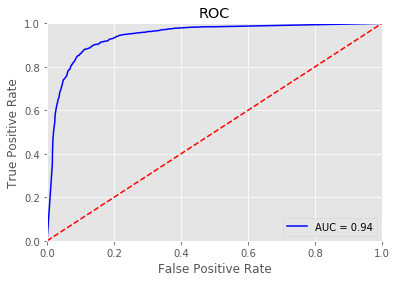

In [203]:
show_auc(scores['predict'])

> ToDo: пояснить за эти графики и поменять комменты на марка дауна

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


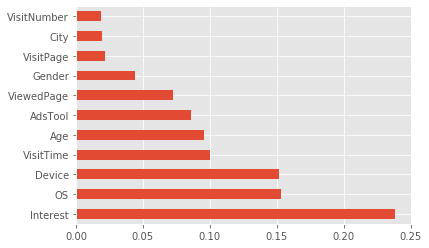

In [204]:
# используйте встроенный класс feature_importances древовидных классификаторов
# построить график важности объектов для лучшей визуализации
extra_tree = ExtraTreesClassifier()
extra_tree.fit(X_train, y_train)
feat_importances = pd.Series(extra_tree.feature_importances_, index=X_train.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()
plt.close()

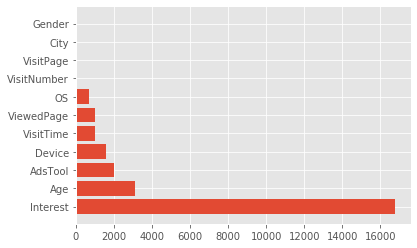

In [205]:
best_features = SelectKBest(score_func=chi2, k=10)

fit = best_features.fit(X_train, y_train)
    # берем результаты
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
    # объединяем 2 фрейма и выводим их в консоль
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
featureScores = featureScores.nlargest(len(data.columns), 'Score')
    
    # выводим график со значением важности по каждому признаку
y_axis = []
y_stickers = []

for j in featureScores.values:
    y_axis.append(j[1])
    y_stickers.append(j[0])

ind = np.arange(len(y_axis))
plt.barh(ind, y_axis, align='center')
plt.yticks(ind, y_stickers)
    
plt.show()
plt.close()

## 2. Леса

#### Случайный лес без настройки параметров

In [208]:
first_forest = RandomForestClassifier(random_state=17,n_estimators=600, max_depth=12, min_samples_leaf=18)
first_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=18, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [209]:
forest_table=[]

scores = count_score(first_forest)
forest_table.append(['First Forest',
                   round(scores['accuracy'], 5),
                   round(scores['auc'], 5),
                   round(scores['rmse'], 5),
                   round(scores['r2'], 5),
                   round(scores['val_score'], 5)])

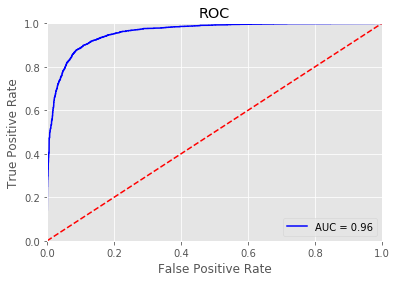

In [210]:
show_auc(scores['predict'])

> TODO mark daun))
поясни за параметры

In [211]:
forest_params = {'max_depth': list(range(12,18)), 'min_samples_leaf': list(range(16,20))}
forest = RandomForestClassifier(random_state=17, n_estimators=600)
locally_best_forest = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1)
locally_best_forest.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=600, n_jobs=None,
                                              oob_score=False, random_state=17,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_d

In [212]:
locally_best_forest.best_params_

{'max_depth': 13, 'min_samples_leaf': 17}

In [213]:
locally_best_forest.best_score_

0.8970714285714285

In [214]:
scores = count_score(locally_best_forest)
forest_table.append(['Locally best Forest',
                   round(scores['accuracy'], 5),
                   round(scores['auc'], 5),
                   round(scores['rmse'], 5),
                   round(scores['r2'], 5),
                   round(scores['val_score'], 5)])

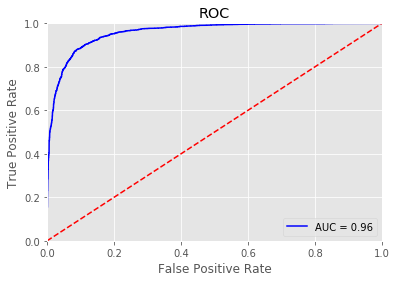

In [215]:
show_auc(scores['predict'])

In [216]:
best_forest = RandomForestClassifier(random_state=17,n_estimators=2000, max_depth=13, min_samples_leaf=17)
best_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=13, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=17, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [217]:
scores = count_score(best_forest)
forest_table.append(['Best Forest',
                   round(scores['accuracy'], 5),
                   round(scores['auc'], 5),
                   round(scores['rmse'], 5),
                   round(scores['r2'], 5),
                   round(scores['val_score'], 5)])

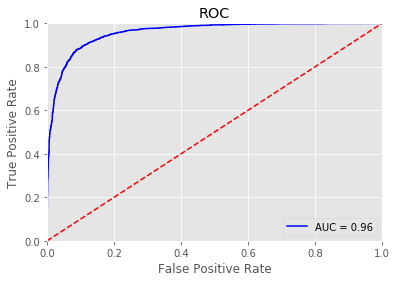

In [218]:
show_auc(scores['predict'])

### Теперь сравним полученные леса

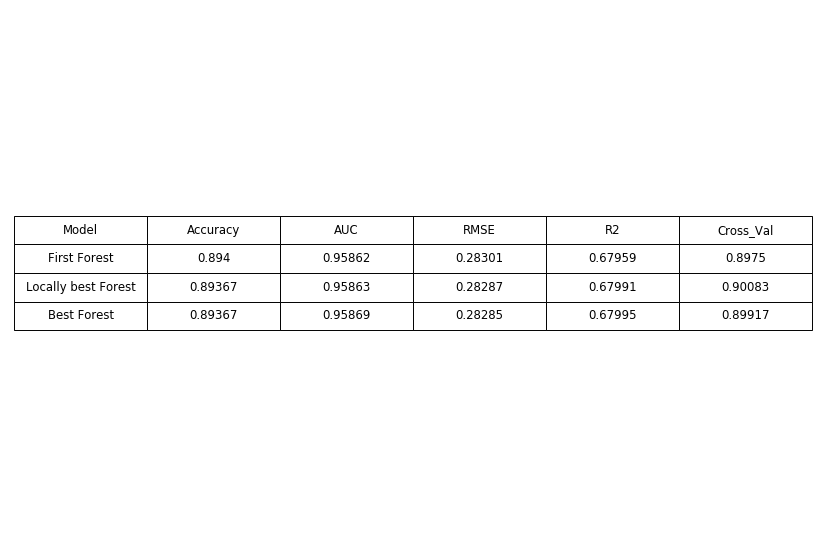

In [219]:
plot_score_table(forest_table)

> **out of bag???**

## 3. Baggggginggggggg

#задаем свойства для классификации по методу Бэггинга
#n_estimators - число деревьев
#random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
#по которым потом вычисляется предсказание.
#oob_score - Следует ли использовать готовые образцы для оценки ошибки обобщения
#n_jobs - по умолчанию стоит 1, но для распределения по ядрам устанавливаем -1
#bootstrap - отрисованы ли множества с заменой. Если False, выполняется выборка без замены.

In [220]:
bag_model = BaggingClassifier(n_estimators=600,
                          n_jobs=-1,
                          random_state=4,
                          oob_score=True,
                          bootstrap=True)
bag_model.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=600,
                  n_jobs=-1, oob_score=True, random_state=4, verbose=0,
                  warm_start=False)

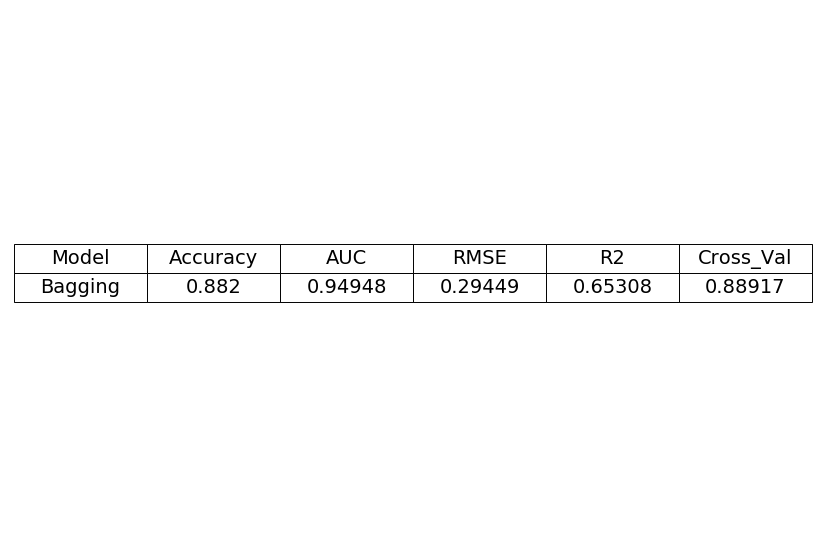

In [221]:
bagging_table = []

scores = count_score(bag_model)
bagging_table.append(['Bagging',
                   round(scores['accuracy'], 5),
                   round(scores['auc'], 5),
                   round(scores['rmse'], 5),
                   round(scores['r2'], 5),
                   round(scores['val_score'], 5)])
plot_score_table(bagging_table)

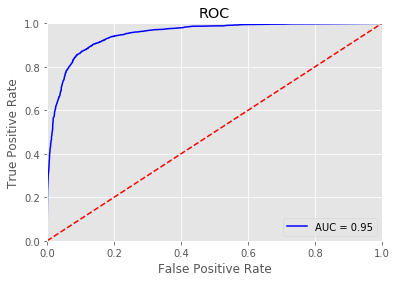

In [222]:
show_auc(scores['predict'])

## 4. Градиентный бустинг 

#задаем свойства для классификации по методу градиентного бустинга
#n_estimators - число шагов
#learning_rate масштабирует длину шага процедуры градиентного спуска
#random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
#по которым потом вычисляется предсказание.
#максимальная глубина 3
#max_features - задача классификации при построении этого ансамбля деревьев рекомендуется брать квадратный корень из всех признаков,
#чтобы деревья были более разнообразными
#warm_start - если True, повторно использовать решения предыдущего вызова для подгонки и добавить дополнительные оценки в ансамбль, 
#в противном случае просто подгонять целый новый ансамбль
#criterion (по дефолту friedman_mse) - функция для измерения качества разделения. 
#Значение по умолчанию «friedman_mse», как правило, является наилучшим, 
#поскольку в некоторых случаях оно может обеспечить лучшее приближение.

In [223]:
gradient = GradientBoostingClassifier(n_estimators=600,
                                   learning_rate=0.1,
                                   max_features='sqrt',
                                   warm_start=True,
                                   random_state=4,
                                   max_depth=3,
                                   criterion='friedman_mse')

gradient.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=600,
                           n_iter_no_change=None, presort='auto',
                           random_state=4, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=True)

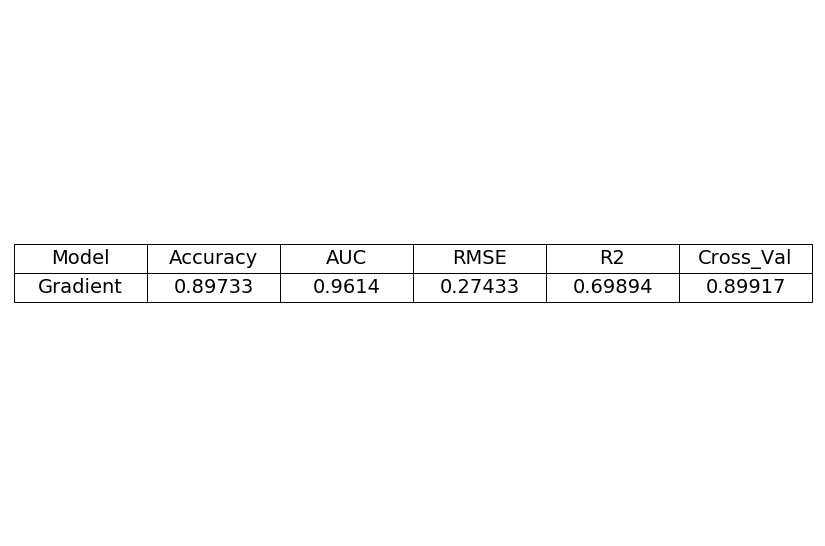

In [224]:
gradient_table = []

scores = count_score(gradient)
gradient_table.append(['Gradient',
                   round(scores['accuracy'], 5),
                   round(scores['auc'], 5),
                   round(scores['rmse'], 5),
                   round(scores['r2'], 5),
                   round(scores['val_score'], 5)])
plot_score_table(gradient_table)

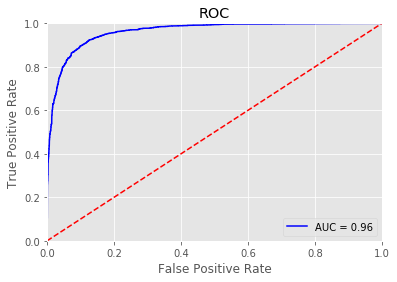

In [225]:
show_auc(scores['predict'])

## 5. Логистическая регрессия

#Логистическая регрессия по методу Лассо (Лассо-регрессия)
#random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
#по которым потом вычисляется предсказание.
#максимально количество иттераций 300
#сбалансировано использует значения y для автоматической настройки весов обратно пропорционально частотам класса входных данных,
#penalty - система наказания по принципу Лассо, т.к l1
#solver - устанавливаем метод оптимизации, т.к маленькая выборка
#multi_class - указывает количетсво признаков, в нашем случае это бинарная классификация 

In [226]:
regr = LogisticRegression(
    random_state=4,
    max_iter=300,
    class_weight='balanced',
    penalty='l1',
    solver='liblinear',
    multi_class='ovr')

regr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=300, multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=4, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [227]:
regr_table = []

scores = count_score(regr)
regr_table.append(['Regression with Lasso',
                   round(scores['accuracy'], 5),
                   round(scores['auc'], 5),
                   round(scores['rmse'], 5),
                   round(scores['r2'], 5),
                   round(scores['val_score'], 5)])

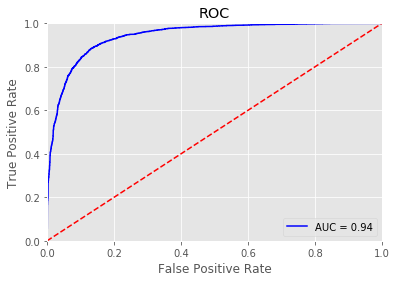

In [228]:
show_auc(scores['predict'])

#Логистическая регрессия по методу Риджа (Ридж-регрессия)
#random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
#по которым потом вычисляется предсказание.
#максимально количество иттераций 300
#сбалансировано использует значения y для автоматической настройки весов обратно пропорционально частотам класса входных данных,
#penalty - система наказания по принципу наименьших квадратов, т.к l2
#multi_class - указывает то, что бинарная классификация 

In [229]:
regr2 = LogisticRegression(
    random_state=4,
    max_iter=300,
    class_weight='balanced',
    penalty='l2',
    multi_class='ovr')
regr2.fit(X_train, y_train)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=300, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=4, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

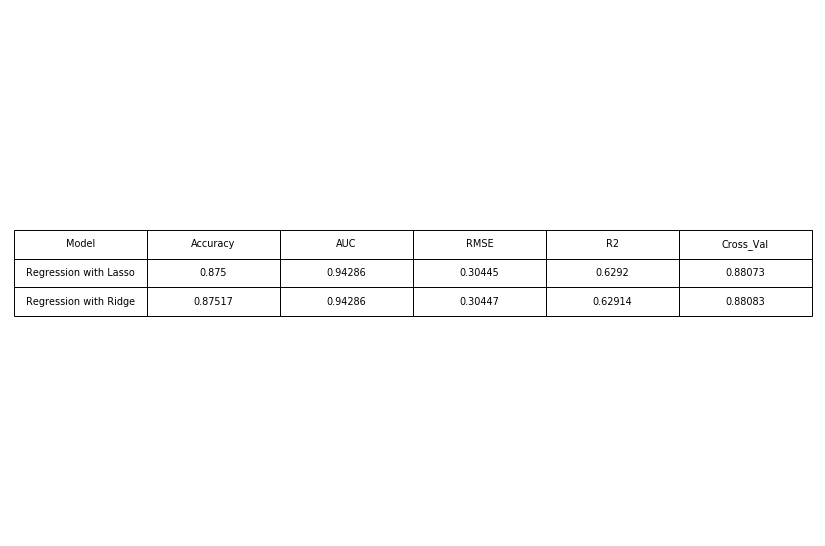

In [230]:
scores = count_score(regr2)
regr_table.append(['Regression with Ridge',
                   round(scores['accuracy'], 5),
                   round(scores['auc'], 5),
                   round(scores['rmse'], 5),
                   round(scores['r2'], 5),
                   round(scores['val_score'], 5)])
plot_score_table(regr_table)

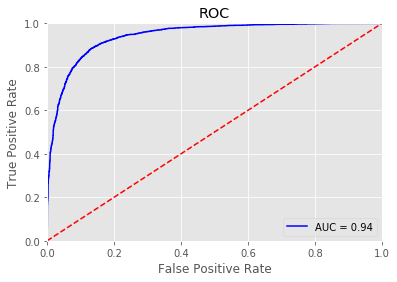

In [231]:
show_auc(scores['predict'])

### Проанализируем данные модели на основе полученных оценок

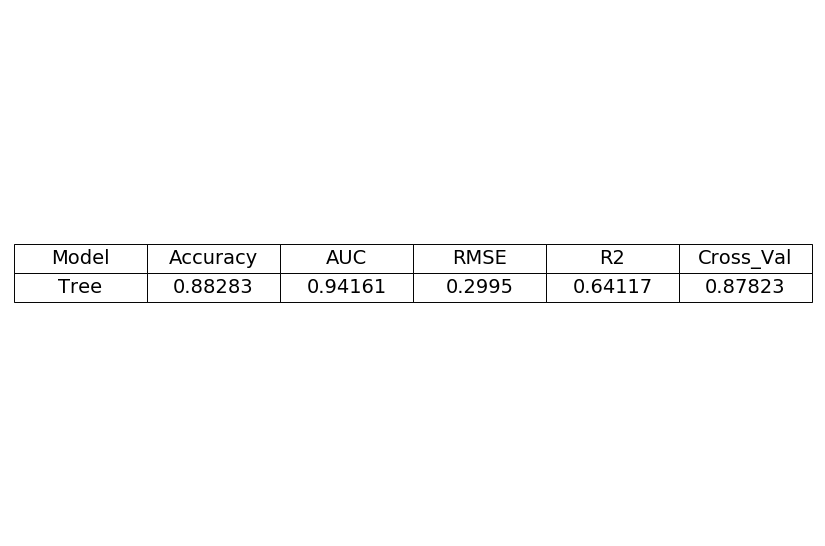

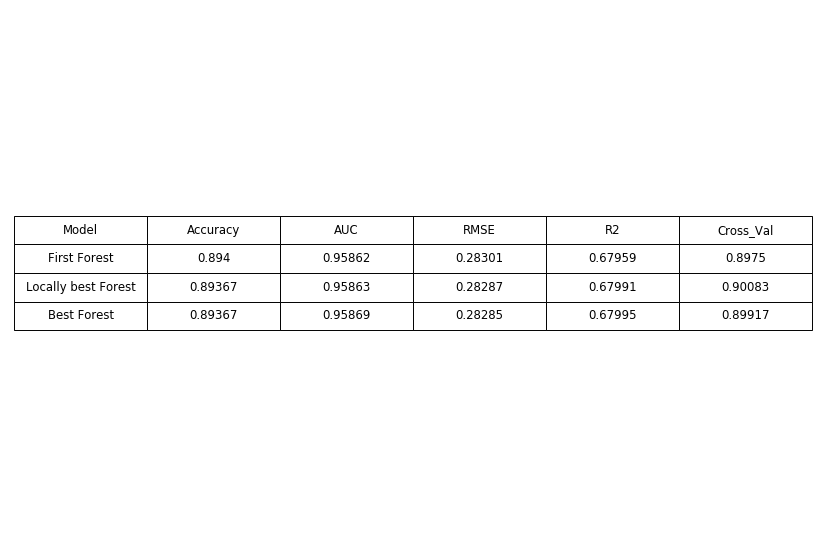

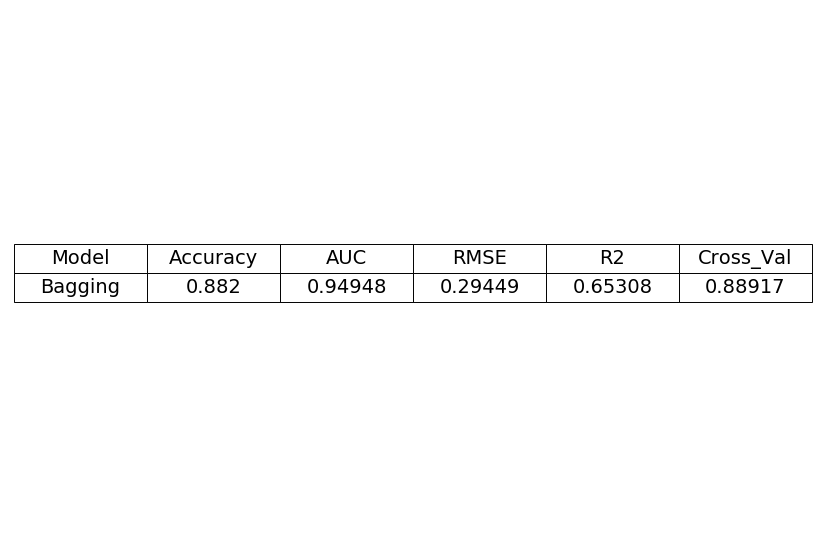

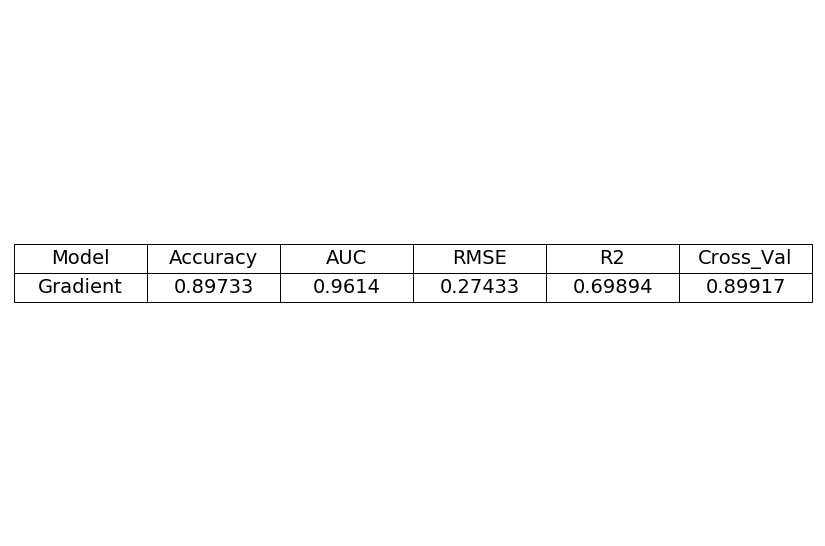

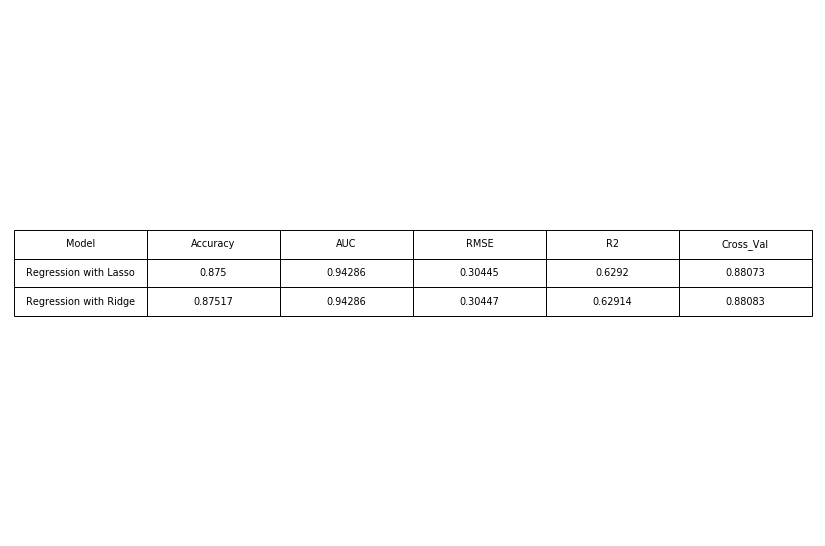

In [232]:
plot_score_table(tree_table)
plot_score_table(forest_table)
plot_score_table(bagging_table)
plot_score_table(gradient_table)
plot_score_table(regr_table)

**Вывод**

- по критерию AUC лучше всего показал себя градиентный бустинг

- по Accuracy тоже градиент, но от леса отличается не сильно

- по RMSE тоже градиент
> ToDo: описать это нормальным языком